
Searching corners and correct perspective

Map computing

Find Thymio
(17, 698)

Thymio connected success
initial thymio pos :  (array([[114., 185.],
       [ 43., 115.],
       [108.,  35.],
       [185., 108.]], dtype=float32), array([112.5 , 110.75], dtype=float32), -2.373375)
--------------------------------------
passed_thymio_pose_camera:  [112.25      110.75       -2.3697991]

dt =  0.1143028736114502
OLD KALMAN MEAN =  [86.02941   84.69118   -1.8149338]
right and left speed (OG units) = , 0   0
v (mms), w (unit?) =  0.0 ,  0.0
mean predicted =  [86.02941132 84.69117737 -1.81493378]
vision position (mm) =  [85.838234 84.69118 ]
innov =  [-0.19117737  0.         -0.55486536]
Kt =  [[0.85106383 0.         0.        ]
 [0.         0.85106383 0.        ]
 [0.         0.         0.85106383]]
correction: kt@innov =  [-0.16270414  0.         -0.47222584]
NEW KALMAN MEAN =  [85.86670717 84.69117737 -2.28715962]

kalman pose:  [112.28723246 110.75000117  -2.28715962]


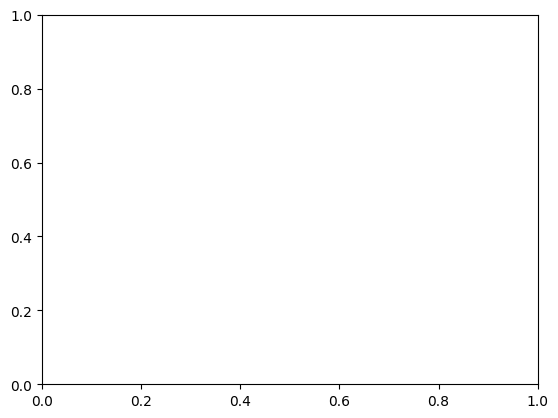

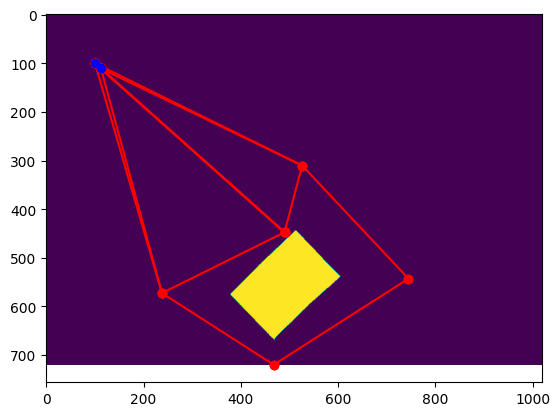

[[112.25 110.75]
 [100.   100.  ]]
go changer de segemnt
cest finit


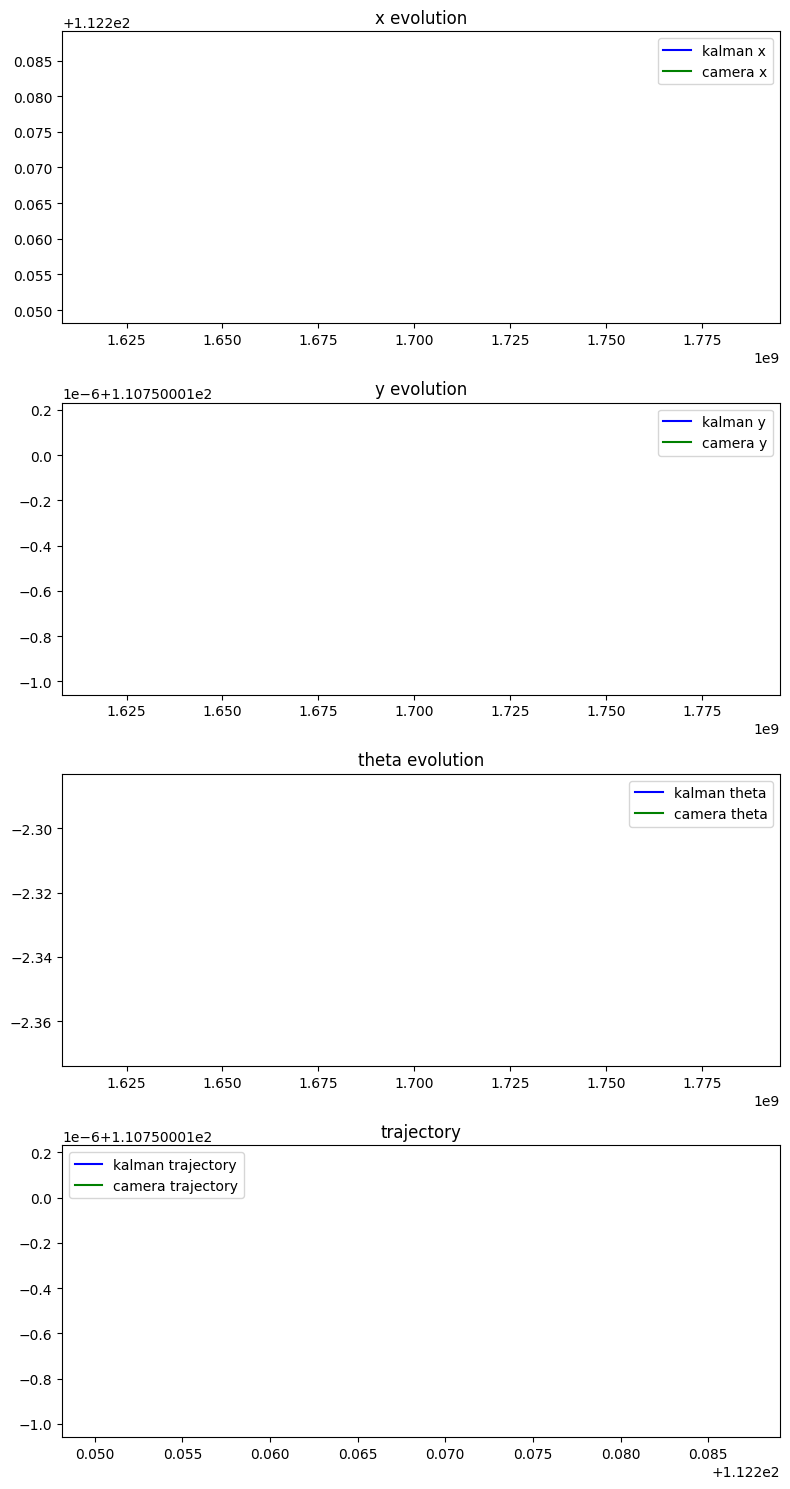

In [1]:
import cv2
import cv2.aruco as aruco
# from skimage.filters import threshold_otsu
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time

from timeit import default_timer as timer
from tdmclient import ClientAsync, aw
from src.FollowPath import*
from src.Obstacle_avoid import*
from Vision.vison_functions import*
from src.globalNavigation import*

from src.kalman import kalman
## A0 paper ratio --> a mesurer pour avoir les distances entre les points tu coco  
res_h = 1020
res_w=720

map_length = 780     # mm

############################ global var ###############################

# ArUco dictionary
dict_id = cv2.aruco.DICT_6X6_50
arucoDict = cv2.aruco.getPredefinedDictionary(dict_id)
arucoParams = cv2.aruco.DetectorParameters()


corner_ids = {
    1:0,
    2:1,
    3:2,
    4:3
}

# Ids
thymio_id = 5


############################ Code ###############################

# Open Camera
cam = cv2.VideoCapture(0)
if not cam.isOpened():
    print("Error: Unable to open the camera.")
else:
    print("\nSearching corners and correct perspective")

cam.set(cv2.CAP_PROP_FRAME_WIDTH, res_h)
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, res_w)

#search for the 4 corner and the right transformation M
M=corners_calibration(cam)

print("\nMap computing")
ret, frame = cam.read()
map = crop_labyrinth(frame, M)
cv2.imwrite("Global_map.png", map)

print("\nFind Thymio")
thymio_pos = None
initial_pos= None
initial_teta = None
#iterate over the few first frame to look for thymio (id=5)
while initial_pos is None and initial_teta is None:
    ret, frame = cam.read()
    dst = crop_labyrinth(frame, M)
    dst_gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    detected = cv2.aruco.detectMarkers(dst_gray, arucoDict, parameters=arucoParams)
    thymio_init = find_thymio(detected)
    (thymio_corners, initial_pos, initial_teta) = thymio_init

#fill the thymio aruco with white
aruco_fill(map, thymio_corners)

#find the obstacle by thresholding
obstacle_map = find_obstacle(map)
cv2.imwrite("Obstacle_map.png",obstacle_map)

end_point=find_end_point(map)
# Check if end_point and thymio_pos are not None before drawing
if end_point is not None:
    # Convert tuple to integers directly
    end_point_int = (int(end_point[0]), int(end_point[1]))
    # Check if the end_point is within the bounds of the map
    if 0 <= end_point_int[0] < obstacle_map.shape[1] and 0 <= end_point_int[1] < obstacle_map.shape[0]:
        cv2.circle(obstacle_map, end_point_int, 5, (0, 0, 255), -1)
    else:
        print("End point is outside the visible region of the map.")
print(end_point)

if initial_pos is not None:
    # Convert tuple to integers directly
    thymio_pos_int = (int(initial_pos[0]), int(initial_pos[1]))
    cv2.circle(obstacle_map, thymio_pos_int, 5, (0, 0, 255), -1)
# Save the image
cv2.imwrite("Obstacle_map+pos.png", obstacle_map)


#################################### main vision algo ########################################

# Thymio connexion
client = ClientAsync()
node = aw(client.wait_for_node())
aw(node.lock())
aw(client.sleep(2))   
print("\nThymio connected success")

# var declarations
start_node = 0
target_node = 1
offset = 100     # elargissement des obstacles
target =  np.array([100,100])
aw(node.set_variables(Msg_motors(0, 0)))
last_position = initial_pos     # in case of error take the last position, only at init.
last_teta = initial_teta

# point_threshold = 20
# area_threshold = 40

#flags
path_has_been_done = 0
do_path = 1             # create a path (initially)

# run the detection of thymio pose to initialize the initial guess for the mean and orientation of the kalman filter
# ret, frame = cam.read()
# dst = crop_labyrinth(frame, M)
# dst_gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
# detected = cv2.aruco.detectMarkers(dst_gray, arucoDict, parameters=arucoParams)
# thymio_pos = find_thymio(detected)     
thymio_pos = thymio_init
print("initial thymio pos : ", thymio_pos)
kalman_class = kalman(map_length_mm=map_length,mean_init=np.array([thymio_pos[1][0],thymio_pos[1][1], thymio_pos[2]])   )  #create an instance object for the class kalman()
# kalman_class.mean_init=[thymio_pos[1], thymio_pos[2]]    #mean is a vector for x,y,theta

motorL=0
motorR=0

curr_time=time.time()       # to not have the first dt very high

kalman_evol = []
vision_evol = []
time_evol = []

start_time = time.time()

while True:
    ret, frame = cam.read()
    dst = crop_labyrinth(frame, M)
    dst_gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    detected = cv2.aruco.detectMarkers(dst_gray, arucoDict, parameters=arucoParams)
    # thymio_pos = find_thymio(detected)        # returns c, position, theta
    ###### edited by me
    thymio_pos = find_thymio(detected)        # returns c, position, theta
    # compute position 
    c, position, teta = thymio_pos          # pose of robot. c is position of edges
    # if position is None : 
    #     position = last_position
    # last_position = position 
    # if teta is None : 
    #     teta = last_teta
    # last_teta = teta
    print("--------------------------------------")
    # print("thymio_pos_camera: ", thymio_pos)
    if (position is not None) and (teta is not None):
        camera_pose = np.array([position[0],position[1],teta])
    else:
        camera_pose = None

    print("passed_thymio_pose_camera: ", camera_pose)
    aw(node.wait_for_variables({"motor.left.speed","motor.right.speed"}))
    l_speed = node.v.motor.left.speed
    r_speed = node.v.motor.right.speed
    prev_time = curr_time
    curr_time = time.time()
    delta_time = curr_time - prev_time
    kalman_pose , kalman_covariance = kalman_class.kalman_update_pose (camera_pose,motorL,motorR, delta_time)        # "pose" contains position and orientation
    print("kalman pose: ", kalman_pose)
    #plot
    kalman_evol.append(kalman_pose)
    vision_evol.append(camera_pose)
    current_timestep = time.time()
    time_evol.append(current_timestep)

    # thymio_pos = np.array([c , kalman_pose[0], kalman_pose[1], kalman_pose[2]])     # remerge into the thymio_pos variable to work with the rest of the code
    thymio_pos = (thymio_pos[0], np.array([kalman_pose[0],kalman_pose[1]]), kalman_pose[2])     
    # print("final thymio pos: ", thymio_pos)
    # print("thymio_pos2: ", thymio_pos)
    #######
    # draw_thymio(dst, thymio_pos)                                                                              # draw
    # Display the frame with detected markers and Thymio
    cv2.imshow('Frame with Detected Markers and Thymio', dst)

    ###### PATH PLANNING ######
    # # compute position 
    # c, position, teta = thymio_pos          # pose of robot. c is position of edges
    # if position is None : 
    #     position = last_position
    # last_position = position 
    # if teta is None : 
    #     teta = last_teta
    # last_teta = teta


    if do_path == 1 :
        
        path, connections, nodelist = run_global(obstacle_map, start_node, position, target_node, target, offset)
        positions_triees = {indice: nodelist[indice] for indice in path}        # nodelist gives all the nodes (directory of nodes)
        pathpoints = np.array(list(positions_triees.values()))[::-1]
        draw_graph(obstacle_map, connections, nodelist, path)
        print(pathpoints)

        do_path = 0
        path_has_been_done = 1
        

    ###### MATION CONTROL ######

    # Bloc to compute the motors speed from obstacles
    aw(node.wait_for_variables({"prox.horizontal"}))
    prox_meas = node.v.prox.horizontal
    motorL_obstacle, motorR_obstacle = LocalAvoidance(prox_meas)

    # Bloc to compute the motors speed from path foloowing 
    motorL_path, motorR_path, has_finished, carrot = follow_path(thymio_pos[1], thymio_pos[2], pathpoints, path_has_been_done)
    path_has_been_done = 0
    # Compute the final motorL value and finale motorR value 
    motorL = motorL_obstacle + motorL_path                      # * 1.01
    motorR = motorR_obstacle + motorR_path                      # * 0.98

    # Limit the motor speed to 500 or -500
    motorL = min(max(motorL, -500), 500)
    motorR = min(max(motorR, -500), 500)

    aw(node.set_variables(Msg_motors(motorL, motorR)))
    if has_finished == 1:
        aw(node.set_variables(Msg_motors(0, 0)))
        aw(node.unlock())
        break

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        aw(node.set_variables(Msg_motors(0, 0)))
        aw(node.unlock())
        break

# kalman_mean_history , kalman_y_history, kalman_timesteps = kalman_class.kalman_plot()
# plt.plot(kalman_timesteps , kalman_mean_history)

#plot:
# print("kalman_evol", kalman_evol)
# print("y_evol: ", vision_evol)
# print("timeevol: ", time_evol )
# print("kalman_evol[5]= ", kalman_evol[5])
# print("y_evol[5]=", vision_evol[5])

for i in range (len(time_evol)) :
    kalman_i = kalman_evol[i]
    kalman_x_evol = kalman_i[0]
    kalman_y_evol = kalman_i[1]
    kalman_theta_evol = kalman_i[2]

    vision_i = vision_evol[i]
    vision_x_evol = vision_i[0]
    vision_y_evol = vision_i[1]
    vision_theta_evol = vision_i[2]

fig, axs = plt.subplots(4, 1, figsize=(8, 15))

# Plot the signals on each subplot
axs[0].plot(time_evol, kalman_x_evol , label='kalman x', color='blue')
axs[0].plot(time_evol, vision_x_evol , label='camera x', color='green')
axs[0].set_title('x evolution')
axs[0].legend()

axs[1].plot(time_evol, kalman_y_evol , label='kalman y', color='blue')
axs[1].plot(time_evol, vision_y_evol , label='camera y', color='green')
axs[1].set_title('y evolution')
axs[1].legend()

axs[2].plot(time_evol, kalman_theta_evol , label='kalman theta', color='blue')
axs[2].plot(time_evol, vision_theta_evol , label='camera theta', color='green')
axs[2].set_title('theta evolution')
axs[2].legend()

axs[3].plot(kalman_x_evol, kalman_y_evol , label='kalman trajectory', color='blue')
axs[3].plot(vision_x_evol, vision_y_evol , label='camera trajectory', color='green')
axs[3].set_title('trajectory')
axs[3].legend()


# Adjust layout to prevent subplot overlap
plt.tight_layout()

# Display the plot
plt.show()


# Release the camera and close all windows
cam.release()
cv2.destroyAllWindows()